## 匯入套件

In [40]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`

from IPython.display import YouTubeVideo

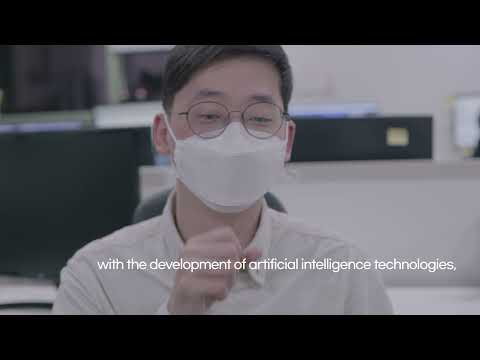

In [41]:
KSL_ID = 'VjainPzPo2k'
YouTubeVideo(KSL_ID)

In [42]:
def download_youtube(youtube_id, start_time=3, duration=20):
  !rm -rf clip*.mp4
  !rm -rf openpose/output/*
  # # download the youtube with the given ID
  !youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://youtu.be/5pZ6bxCWSjQ
  # just pick a section where sign language is done
  !ffmpeg -y -loglevel info -ss $start_time -t $duration -i youtube.mp4 clip.mp4
  # # detect poses on the these 10 seconds
  !rm openpose.avi
  !cd openpose && ./build/examples/openpose/openpose.bin --face --hand --video ../clip.mp4 --write_json ./output_json/ --display 0  --write_video ../clip_openpose.avi
  # convert the result into MP4
  !ffmpeg -y -loglevel info -i clip_openpose.avi clip_openpose.mp4

download_youtube(KSL_ID)

[youtube] 5pZ6bxCWSjQ: Downloading webpage
[youtube] 5pZ6bxCWSjQ: Downloading MPD manifest
[download] youtube.mp4 has already been downloaded
[download] 100% of 3.12MiB
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --ena

In [43]:
!pip install tf_pose
import tf_pose

from tf_pose import common
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh

model='mobilenet_thin'
resize='432x368'
w, h = model_wh(resize)
if w == 0 or h == 0:
    e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
else:
    e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))

  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


[2021-12-22 05:26:41,171] [TfPoseEstimator] [INFO] loading graph from /usr/local/lib/python3.7/dist-packages/tf_pose_data/graph/mobilenet_thin/graph_opt.pb(default size=432x368)


TfPoseEstimator/MobilenetV1/Conv2d_0/weights
TfPoseEstimator/image
TfPoseEstimator/MobilenetV1/Conv2d_0/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_0/Conv2D_bn_offset
TfPoseEstimator/MobilenetV1/Conv2d_0/BatchNorm/FusedBatchNorm
TfPoseEstimator/MobilenetV1/Conv2d_0/Relu
TfPoseEstimator/MobilenetV1/Conv2d_1_depthwise/depthwise_weights
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/weights
TfPoseEstimator/MobilenetV1/Conv2d_1_depthwise/depthwise
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Conv2D_bn_offset
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/BatchNorm/FusedBatchNorm
TfPoseEstimator/MobilenetV1/Conv2d_1_pointwise/Relu
TfPoseEstimator/MobilenetV1/Conv2d_2_depthwise/depthwise_weights
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/weights
TfPoseEstimator/MobilenetV1/Conv2d_2_depthwise/depthwise
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/Conv2D
TfPoseEstimator/MobilenetV1/Conv2d_2_pointwise/Conv2D_bn_offset
TfPoseEstimator/M

## 即時錄影辨識

In [44]:
import base64
import html
import io
import time

from IPython.display import display, Javascript
from google.colab.output import eval_js
import numpy as np
from PIL import Image
import cv2

def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }

    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def take_live_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [45]:
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam

    output: 
          image_array: image array from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    return np.asarray(image_PIL)

def image_to_bytes(image_openpose):
    image = Image.fromarray(image_openpose, 'RGB')
    iobuf = io.BytesIO()
    image.save(iobuf, format='png')
    drawing_bytes = 'data:image/png;base64,{}'.format((str(base64.b64encode(iobuf.getvalue()), 'utf-8')))
    return drawing_bytes

In [48]:
start_input()
label_html = 'Capturing...'
img_data = ''

while True:
    js_reply = take_live_photo(label_html, img_data)
    if not js_reply:
        break

    image = js_reply_to_image(js_reply)

    humans = e.inference(image,
                         resize_to_default=(w > 0 and h > 0),
                         upsample_size=4.0)
    image_openpose = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)

    drawing_bytes = image_to_bytes(image_openpose)
    img_data = drawing_bytes

<IPython.core.display.Javascript object>

# 拍照辨識

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(imgData, quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


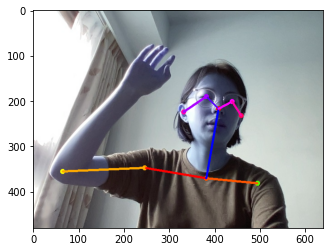

In [ ]:
from IPython.display import Image
import matplotlib.pyplot as plt

try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  image = cv2.imread(filename)
  humans = e.inference(image,
                        resize_to_default=(w > 0 and h > 0),
                        upsample_size=4.0)
  image = TfPoseEstimator.draw_humans(image, humans, imgcopy=False)
  plt.imshow(image)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))